# Corn Disease Classification

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=40

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/corn.zip'

Archive:  /content/drive/MyDrive/corn.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Corn_Blight (1010).JPG  
  inflating: data/Blight/Corn_Blight (1011).jpg  
  inflating: data/Blight/Corn_Blight (1012).JPG  
  inflating: data/Blight/Corn_Blight (1013).JPG  
  inflating: data

### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[3 1 0 2 2 0 2 2 1 3 1 3 1 1 1 3 1 3 0 2 3 0 3 3 0 0 2 0 0 3 0 3 1 3 1 0 1
 0 1 1 2 0 3 3 1 0 0 3 1 2 2 0 1 3 3 1 3 0 0 0 2 3 3 3]


### Visualize some of the images from our dataset

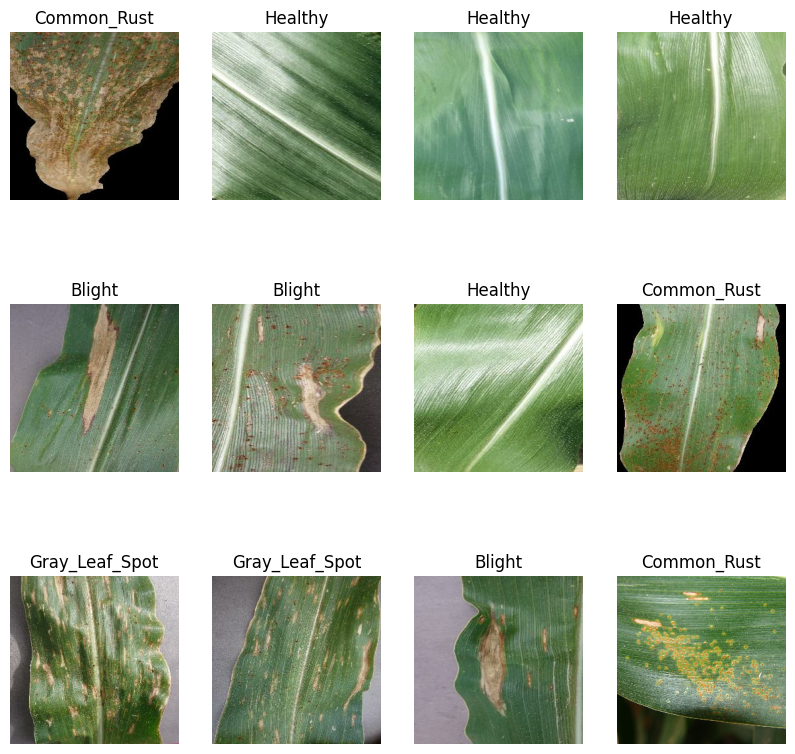

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

27

In [ ]:
train_size = 0.8
len(dataset)*train_size

21.6

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

27

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [ ]:
val_size=0.1
len(dataset)*val_size

2.7

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

21

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

4

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
52/52 [==============================] - 56s 754ms/step - loss: 0.9438 - accuracy: 0.5944 - val_loss: 0.5490 - val_accuracy: 0.8047
Epoch 2/40
52/52 [==============================] - 34s 656ms/step - loss: 0.4868 - accuracy: 0.8110 - val_loss: 0.4943 - val_accuracy: 0.7891
Epoch 3/40
52/52 [==============================] - 31s 596ms/step - loss: 0.4002 - accuracy: 0.8350 - val_loss: 0.4473 - val_accuracy: 0.8125
Epoch 4/40
52/52 [==============================] - 30s 576ms/step - loss: 0.3752 - accuracy: 0.8495 - val_loss: 0.3970 - val_accuracy: 0.8307
Epoch 5/40
52/52 [==============================] - 35s 663ms/step - loss: 0.3731 - accuracy: 0.8537 - val_loss: 0.3952 - val_accuracy: 0.8490
Epoch 6/40
52/52 [==============================] - 35s 666ms/step - loss: 0.3685 - accuracy: 0.8594 - val_loss: 0.3715 - val_accuracy: 0.8516
Epoch 7/40
52/52 [==============================] - 31s 598ms/step - loss: 0.3323 - accuracy: 0.8756 - val_loss: 0.3605 - val_accuracy: 0.8411

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 47ms/step - loss: 0.2311 - accuracy: 0.9102


In [ ]:
scores

[0.2310675084590912, 0.91015625]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 52}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

40

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9437960982322693,
 0.4868098795413971,
 0.40024083852767944,
 0.37521445751190186,
 0.3731105625629425]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

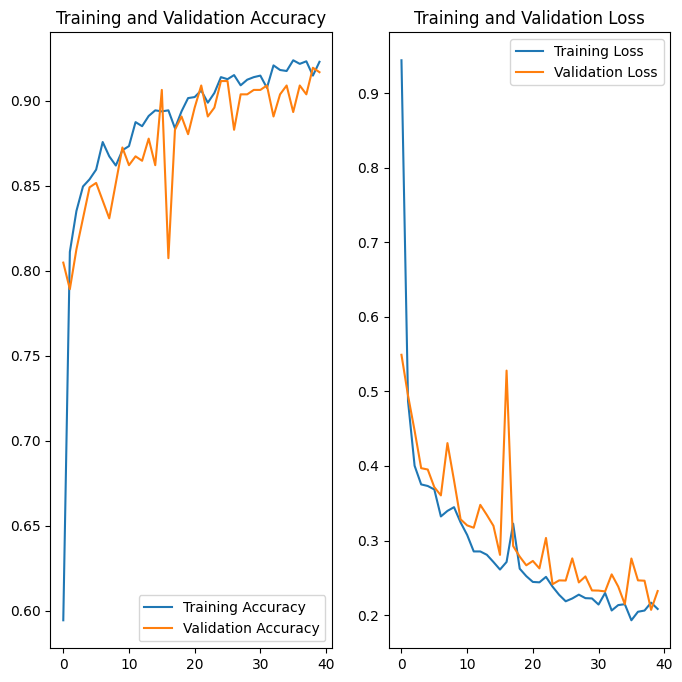

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Healthy
2/2 [==============================] - 1s 13ms/step
predicted label: Healthy


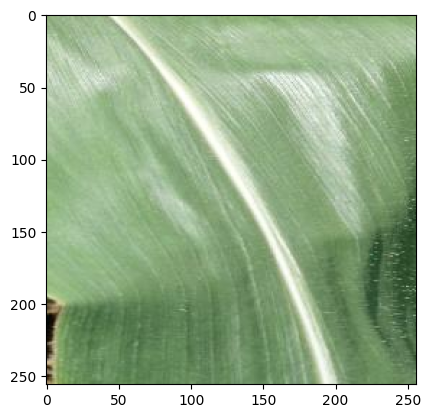

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

### Saving the Model


In [ ]:
model_json = model.to_json()
with open("cotton.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("cotton.h5")
print("Saved model to disk")

Saved model to disk
